
If you are not using this notebook in Google Colabs, please install the package on your own computer, download the data from figshare, and then skip ahead to the data loading step. 

---
### Install the Popalign repo
---

The user can install PopAlign with the following command:

`pip install git+https://github.com/thomsonlab/popalign`

In general, we recommend installing the PopAlign package and its required dependencies in a dedicated environment (created with Anaconda for example). This package is built to run in Python 3 and will not work with Python 2.

After installing the PopAlign package with pip, the user can import it in their Python code:

`import popalign as PA`




In [ ]:
!pip install git+https://github.com/thomsonlab/popalign.git

In [ ]:
import popalign as PA

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm




---

### Mount Google Drive into colab

---



In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd 'drive/My Drive/'

/content/drive/My Drive


In [ ]:
# !mkdir 'PopAlignTutorial'
%cd 'PopAlignTutorial'

/content/drive/My Drive/PopAlignTutorials/Tutorial1


In [ ]:
ls

data_inprogress_v1.pickle  __MACOSX/  output_drugscreen/  PopAlign_Data/


---
The following codeblock is useful for saving your progress.  

When you want to take a break, uncomment the save block and execute.  

When you want to load, comment the save block and uncomment the load block.  Make sure that the save block is commented otherwise you will accidentally overwrite the file. 

In [ ]:
import pickle

# '''
# Save data from a multiplexed experiment
# '''
# with open('data_inprogress_v1.pickle', 'wb') as handle:
#     pickle.dump(pop, handle)

# '''
# Load data from a multiplexed experiment
# '''
# with open('data_inprogress_v1.pickle', 'rb') as handle:
#     pop = pickle.load(handle)


---

### Grab the Drug Response data from PopAlign figshare link 
https://doi.org/10.6084/m9.figshare.11837097




In [ ]:
!wget  --no-check-certificate https://ndownloader.figshare.com/files/24645260

# If the above link is not correct, go to the doi link, 
# right-click on the Download button and select 'Copy Link Address'


--2020-09-11 05:36:07--  https://ndownloader.figshare.com/files/24645260
Resolving ndownloader.figshare.com (ndownloader.figshare.com)... 54.154.218.131, 34.242.50.74, 34.248.227.192, ...
Connecting to ndownloader.figshare.com (ndownloader.figshare.com)|54.154.218.131|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://s3-eu-west-1.amazonaws.com/pfigshare-u-files/24645260/PopAlign_Data.zip [following]
--2020-09-11 05:36:07--  https://s3-eu-west-1.amazonaws.com/pfigshare-u-files/24645260/PopAlign_Data.zip
Resolving s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)... 52.218.97.18
Connecting to s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)|52.218.97.18|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 242971639 (232M) [application/zip]
Saving to: ‘24645260’

24645260            100%[===================>] 231.71M  47.8MB/s    in 5.0s    

2020-09-11 05:36:12 (46.4 MB/s) - ‘24645260’ saved [242971639/242971639]



In [ ]:
!unzip 24645260

In [ ]:
%rm 24645260

---

### First we will load in data from raw files. 

---

In this tutorial, we will use the drug screen dataset from the PopAlign paper. This dataset was produced using multiplexing (Multi-seq). 

For multiplexed experiments, we store all cells into a single matrix file, and store sample information for each cell in a metadata file. This format requires the paths to the .mtx file, the gene list, the barcode list and a metadata file. The meta data file must be a .csv file that includes at least two columns:
cell_barcode and sample_id . The first column contains the cell barcodes and the second column contains the matching sample names for those cells. The cells from the different samples will be selected from the matrix based on their barcode index.

If you do not have multiplexed data, you can also use `PA.load_samples()` to load samples from individual files. 

Both loading functions (`PA.load_multiplexed()` and `PA.load_samples()`) produce a dictionary that contains the loaded data, genes and various information. That object (`pop`) is used throughout the entire analysis. The `outputfolder` parameter (default: 'output') defines where the results of the analysis will be saved. 

You can load more data into an existing pop object by specifying the `existing_obj` parameter (default: `None`)

The sample gene expression matrices are stored individually within the pop object. To access the gene expression matrix of 'sample1', use the following:

`pop['samples']['sample1']['M']`

The gene labels are stored in the pop object:

`pop['genes']`

Important: Make sure to provide valid gene ids. Some custom references modify the gene ids, and will cause downstream issues when performing GSEA or cell typing, which rely on correct gene names. 



In [ ]:
# Load in data from raw files to rerun entire analysis. 
# Please note that some of the results may shift due to slightly different parameters that are learnt.
# Additionally you will have to manually adjust some variables (like component number) in
# the code to account for changes in how the components are numbered. 
'''
Load data from a screen experiment and genes from a file

Parameters
----------
matrix : str
  Path to a sparse matrix
barcodes : str
  Path to a .tsv 10X barcodes file
metafile : str
  Path to a metadata file. Must contains `cell_barcodes` and `sample_id` columns
controlstring: string
  String containing common name across all control samples 	
genes : str
  Path to a .tsv 10X gene file. Optional if existing_obj is provided
outputfolder : str, optional
  Path (or name) of the output folder to create
existing_obj : dict, optional
  Object previously returned by either load_samples() or load_screen(). New samples will be added to that object
only : list, optional
  List of sample names to load (other samples with names not in list will not be loaded)
col : str, optional
  Name of a specific column in the meta data to use
value : str or int, optional
  Value in the specified meta data column `col` to use to filter samples to load
'''

folder = 'PopAlign_Data/drugscreen/'

mymatrix = folder + 'drugscreen.mtx'
mybarcodes = folder + 'barcodes.tsv'
mygenes = folder + 'features.tsv'
mymetadata = folder + 'meta.csv'

pop = PA.load_multiplexed(matrix=mymatrix, 
                     barcodes=mybarcodes,
                     genes=mygenes,
                     metafile=mymetadata,
                     controlstring='CTRL', # This can also be directly reset later using: pop['controlstring'] = 'newname'
                     outputfolder='output_drugscreen',
                     only=[], # list of sample names to only load the specified samples
                     col=None, # either None or a column name from the meta data
                     value=None, # if col != None, specify value in column to filter samples
                     existing_obj=None)

You can use the PA.print_ncells() command to print the number of cells loaded into each sample: 

In [ ]:
PA.print_ncells(pop)

Meprednisone 	 943
Dexrazoxane HCl (ICRF-187, ADR-529) 	 720
Etodolac 	 898
Phenylbutazone 	 671
Pomalidomide 	 804
Budesonide 	 726
Loteprednol etabonate 	 646
CTRL6 	 695
Betamethasone Valerate 	 1004
Febuxostat 	 848
Sulfasalazine 	 796
CTRL2 	 433
Flurbiprofen 	 834
Mianserin HCl 	 744
Naproxen Sodium 	 670
CTRL4 	 592
Triamcinolone Acetonide 	 866
Acetylcysteine 	 903
Everolimus (RAD001) 	 486
Isotretinoin 	 927
Ibuprofen 	 893
Doramapimod (BIRB 796) 	 908
Allopurinol Sodium 	 666
Tranilast 	 1081
Cyclosporine 	 738
Adapalene 	 806
Thalidomide 	 603
Celecoxib 	 652
CTRL3 	 668
Ketoprofen 	 750
Loratadine 	 545
Tazarotene 	 859
Bimatoprost 	 899
Cetirizine DiHCl 	 426
Mesalamine 	 589
Mercaptopurine (6-MP) 	 625
CTRL1 	 476
Busulfan 	 703
CTRL5 	 721
Zafirlukast 	 863
Zileuton 	 891
Latrepirdine 2HCl 	 838
Rapamycin (Sirolimus) 	 337
Alprostadil 	 749
Masitinib (AB1010) 	 291
Methotrexate 	 699
Total number of cells loaded: 33482


---

### Normalization

---

Next we will normalize each dataset. 

We normalize by using the following equation: 

\begin{align}
g'_i = \log(\beta \frac{g_i}{\sum_{i}^{n}{g_i}}  + 1) 
\end{align}

where $n$ is the total number of genes, and $\beta$ is a scaling factor, and we add a $1$ pseudo-count to each gene expression value. Dividing by the total number of transcripts per cell allows us to correct for technical differences in transcript capture per cell.  Scaling by $\beta$ enables us to rescale the value so that the quantity inside the $log()$ is roughly equal to the number of raw transcripts collected. We found that by setting $\beta =1000$ (roughly the median number of total transcript counts in a cell), we achieve a smooth transition in the distribution of transformed $g'_i$ when raw $g_i$ values step from $0$ to $1$.

The scaling factor value can be either set by the user or computed automatically (`scaling_factor=None`). When computed automatically, multiple factors are tested and the factor that minimizes the difference between the mean of the original data D prior to normalization and the mean of the normalized, scaled data is used.

The normalization function is:

`PA.normalize(pop, scaling_factor=None, ncells=None)`

Gene expression matrices are normalized in-place, i.e. the matrices are directly updated in the pop object (`pop['samples']['sample1']['M']`). `ncells` sets the number of randomly subsampled cells used to compute the scaling_factor. If `None`, all cells are used. 


In [ ]:
'''
Normalize the samples of object `pop` and applies a normalization factor

Parameters
----------
pop : dict
    Popalign object
scaling_factor : int or None, optional
    Number used to scale the data values. If None, that factor is computed automatically
ncells : int or None
    Number of cells to randomly subsample to try different normalization factors to use less memory. If None, all cells are used.
'''

PA.normalize(pop, scaling_factor=1000)

Performing column normalization


In [ ]:
import numpy as np

---

### Gene Filtering 

---

Most genes in the dataset will not be very informative, as they will be expressed at very low levels (near or at 0) or are not expressed differentially between datasets or subpopulations. To filter out only the most informative genes, we find genes whose variance are higher than would be predicted by a Poisson distribution (for which $CV = \frac{1}{\sqrt(mean)}$) . Thus, we plot for all genes: log(CV) ~ log(mean). All genes will lie along a $ y = - 1/2 x $ line, but genes which have CV above that line are supra-Poisson. You can set the `offset` to that y=-½ x line that adjusts the filter threshold. The log of the offset parameter is added to the fitted line's intercept (i.e. `offset = 1` will result in no change to the line).

Plot is displayed in line and saved in: output/qc/gene_filtering.pdf

Once supra-Poisson genes are determined using `plot_gene_filter()`, we use the `filter()` function to generate a filtered and logged version of the data. `filter()` also provides options to eliminate ribosomal genes starting with RPS or RPL (`remove_ribsomal=True`) or mitochondrial genes starting with MT(`remove_mitochondrial=True`). 

The filtered and logged matrices are stored as 'M_norm', and can be accessed with: 

`pop['samples']['sample1']['M_norm']`

The non-filtered matrices are also logged in-place. The filtered genes can be accessed with:

`pop['filtered_genes']`



1081 genes selected


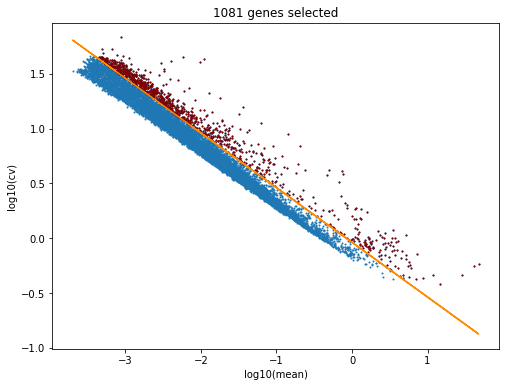

In [ ]:
'''
Plot genes by their log(mean) and log(coefficient of variation)
Can be used multiple times to find best offset

Parameters
----------
offset: float
    Value (its log) will be added to the intercept of the linear fit to filter genes
'''

PA.plot_gene_filter(pop, offset=1.3)

In [ ]:
'''
Filter genes from data in `pop`
Can discard ribosomal genes that start with RPS or RPL
Can discard mitochondrial genes that start with MT-

Parameters
----------
pop :dict
    Popalign object
remove_ribsomal : bool
    Wether to remove or not the ribosomal genes
remove_mitochondrial : bool
    Wether to remove or not the mitochondrial geneset
'''
PA.filter(pop, remove_ribsomal=False, remove_mitochondrial=False)

Filtering genes and logging data


In [ ]:
len(pop['filtered_genes'])

1081

---
You can also remove red blood cells from the data based on high expression of  hemoglobin genes. We use the following genes: 

*  Mouse: 'HBB-BT','HBB-BS' ,'HBA-A1','HBA-A2','HBB-B1','HBB-B2'
*  Human: 'HBB', 'HBA1', 'HBA2'

We sum the expression level for these genes, and use Otsu's method to find a threshold between two peaks.  Cells which exceed the threshold are flagged as red blood cells and removed from the analysis. 

We do not do this for the PBMC drugscreen dataset since we do not find red blood cells after extended culture (> 24hr).


In [ ]:
'''
Remove red blood cells from data

Parameters
----------
pop : dict
    Popalign object
species : str
    name of experiment species. Can be human or mouse
'''
# PA.removeRBC(pop, species='human')

---

### Dimensionality reduction

---

We build models in a common low-dimensional space defined by gene expression features or programs, which can be discovered using many linear dimensionality reduction techniques. Using a linear dimensionality reduction method is important for preserving distance after transformation. 

In the package, we support both features built from principal components analysis (PCA) or orthogonal non-negative matrix factorizaion (oNMF), although support is more extensive for oNMF features (i.e. we are still developing downstream compatibility for models built with PCA features). 

oNMF factors the original data matrix, $D^\text{train}$, into two matrices $D \approx FC$. $F$ is a $n x m$ matrix of features, where each column is a feature vector, n is the number of genes, and m is the number of features. $C$ is a $m x k$ matrix of coefficients multiplying those features, where k is the number of cells. Factorization occurs through minimization of an objective function with positivity and orthogonality constraints:  

\begin{align}
&\arg\min_{FC}  || D^\text{train} - F   C||_2 \nonumber \\
& \text{subject to } \ F^T F = I , C_{i j} \geq 0, F_{i j} \geq 0, 
\end{align}

The positivity constraints on $F$ and $C$, and orthogonality constraint on $F$ compel a parts-based representation (Lee and Seung, 1999). This means feature vectors tend to capture blocks of genes which co-occur, and are orthogonal to each other. 

After running the oNMF algorithm (implemented , each feature vector is normalized by their respective L2-norm, so that each unit of distance along a feature corresponds to the same unit distance in the original gene expression space. 

To choose the number of features, we first compute the oNMF featuresets across a range of $m$ and then select the number of features ($m) that optimizes a loss function described in the next section. 

**References:**

Lee, D. D., and H. S. Seung. 1999. “Learning the Parts of Objects by Non-Negative Matrix Factorization.” Nature 401 (6755): 788–91.

Y. Li and A. Ngom, "The non-negative matrix factorization toolbox for biological data mining," BMC Source Code for Biology and Medicine, vol 8, pp. 10, April 2013.


In [ ]:
'''
Compute feature spaces and minimize the reconstruction error to pick a final feature space
Run Gene Set Enrichment Analysis (GSEA)

Parameters
----------
pop : dict
    Popalign object
ncells : int
    Number of cells to use
nfeats : int or list of ints
    Number(s) of features to use
nreps : int
    Number of repetitions to perform for each k in nfeats
niter : int
    Maximum number of iterations to perform for each instance of the algorithm
'''

PA.onmf(pop, ncells=5000, nfeats=list(range(1,20)), nreps=2, niter=500);

Computing W matrices
Orthogonal NMF performed with 201 iterations

Orthogonal NMF performed with 201 iterations

Orthogonal NMF performed with 500 iterations

Orthogonal NMF performed with 500 iterations

Orthogonal NMF performed with 500 iterations

Orthogonal NMF performed with 500 iterations

Orthogonal NMF performed with 500 iterations

Orthogonal NMF performed with 500 iterations

Orthogonal NMF performed with 500 iterations

Orthogonal NMF performed with 500 iterations

Orthogonal NMF performed with 500 iterations

Orthogonal NMF performed with 500 iterations

Orthogonal NMF performed with 500 iterations

Orthogonal NMF performed with 500 iterations

Orthogonal NMF performed with 500 iterations

Orthogonal NMF performed with 500 iterations

Orthogonal NMF performed with 500 iterations

Orthogonal NMF performed with 500 iterations

Orthogonal NMF performed with 500 iterations

Orthogonal NMF performed with 500 iterations

Orthogonal NMF performed with 500 iterations

Orthogonal NM

In [ ]:
len(pop['filtered_genes'])

1081

---

### Selecting the number of features

---

To perform oNMF, we must select $m$, the number of features to be extracted through.  Choosing $m$ involves balancing the tension between the 'expressiveness' in the feature set and its dimensionality. Higher $m$ reduces the error in the representation while also breaking up blocks of genes into smaller modules that represent independent gene expression pathways with finer granularity. However, as $m$ increases, the typical computational and sampling challenges associated with high dimensionality emerge. 

Practically, we balance this tension in PopAlign by constructing a loss function with a penalty that increases with $m$: 

\begin{align}
\arg \min_{m} \ f(m) = MSE + j \cdot c_{\alpha,0}\cdot m^{\alpha}
\end{align}

First, we compute the mean squared error (MSE):  $ \ \frac{1}{n} ||D^{\text{train}} - F_m C_m||^2$.  This error is, then, incremented by the righthand term, which penalizes higher values of $m$ and hence the dimensionality of the feature set.   To standardize the analysis computationally, we normalize the MSE values by their maximum value. Then, for each $\alpha$, we define the baseline constant as: $c_{\alpha,0} = 0.1 / (m_{max})^{\alpha}$ (PopAlign default $m_{max}=30$). This baseline constant tunes the penalty term to be a similar scale to the MSE curve, while the multiplier j gives the user the flexibility to modulate the exact value of the constant.  We compute the $f(m)$ curves for various values of $\alpha$ and its associated constant $c_{\alpha}$, and allow the user to choose parameter settings in order to achieve a coarser or finer decomposition of cell state.

Once the featureset is chosen, we cast the entire data into the chosen featureset using non-negative least squares. For each cell's gene expression profile $g$, we find the coefficients vector, $c$ : 

\begin{align}
&\arg\min_{c} ||g - F \ c||_2 \ , \
& c_i \geq 0
\end{align}


To access the feature space:

`pop['W']`

To access the feature data of sample1 in feature space, use the following:

`pop['samples']['sample1']['C']`

Gene set enrichment analysis (GSEA) is run for each feature from the feature space. The top feature labels can be found here:

`pop['top_feat_labels']`

To acess the top 20 gene set labels assigned to each feature:

`pop['feat_labels']`


Retrieving oNMF featureset with lowest f(m): 


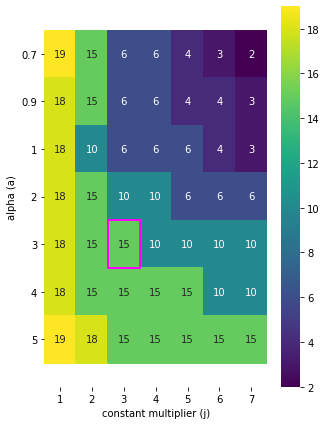

Featureset with 15 features loaded
Projecting into selected featureset...
Starting gene set enrichment analysis
0 GO_LENS_FIBER_CELL_DEVELOPMENT
1 GO_POSITIVE_REGULATION_OF_RESPONSE_TO_STIMULUS
2 GO_NEGATIVE_REGULATION_OF_RESPONSE_TO_OXIDATIVE_STRESS
3 GO_ESTABLISHMENT_OF_PROTEIN_LOCALIZATION_TO_ENDOPLASMIC_RETICULUM
4 GO_RESPIRATORY_BURST
5 GO_NEGATIVE_REGULATION_OF_STEROL_TRANSPORT
6 GO_PROTEIN_LOCALIZATION
7 GO_ESTABLISHMENT_OF_PROTEIN_LOCALIZATION_TO_ENDOPLASMIC_RETICULUM
8 GO_POSITIVE_REGULATION_OF_RESPONSE_TO_STIMULUS
9 GO_ESTABLISHMENT_OF_PROTEIN_LOCALIZATION_TO_ENDOPLASMIC_RETICULUM
10 GO_RESPONSE_TO_INORGANIC_SUBSTANCE
11 GO_GLIAL_CELL_DEVELOPMENT
12 GO_CELLULAR_IRON_ION_HOMEOSTASIS
13 GO_ANTIGEN_PROCESSING_AND_PRESENTATION_OF_PEPTIDE_OR_POLYSACCHARIDE_ANTIGEN_VIA_MHC_CLASS_II
14 GO_PLATELET_AGGREGATION


In [ ]:
'''
Choose featureset from stored oNMF calculations. 
Either user directly supplies a preferred m value or the hyperparameters for the loss function 

NB: Currently only supports oNMF features

Parameters
----------
errors : list
  list of MSE errors from oNMF
alpha : float
  power of polynomial
multiplier : float
  multiplies constant C in f(m)

Plots can be found in output folder: qc/features/

'''

# save files for one featureset
PA.choose_featureset(pop, alpha = 3, multiplier=3)

---

### Build probabilistic models

---

The PopAlign framework builds probabilistic models of each sample and uses these models to compare samples at the population, subpopulation, and gene expression level. 

All samples are modeled with a Gaussian Mixture Model (GMM). A GMM is a mixture of Gaussian densities that fit a given set of data points in an m-dimensional feature space. 

\begin{align}
P(c)= \sum^{k}_{i=1} w_i \ \mathcal{N}(c; \mu_i, \Sigma_i) \nonumber
\end{align}

Each Gaussian $\mathcal{N}_i$ is parameterized with : 

*   mean ($\mu_i$}: describes the mean cell-state in terms of gene expression features [m x 1 vector]
*   covariance matrix ($\Sigma_i$): describes spread and shape of the local density [m by m matrix]
*   weight($w_i$): describes the relative proportion of this density in the model [scalar]

Models are fit using sci-kit learn with expectation-maximization. To find the best possible model for a sample, build_gmms() scans over a list of component numbers (`ks`), and build multiple replicates for each k. For a given sample, the sample data is split into two sets: a training set and a validation set. The training set is used to fit the GMMs and the validation set is used to evaluate model performance. Once all models are fit, the validation set is used to rank the models based on either the Bayesian Information Criterion (BIC) or Akaike Information Criterion (AIC). We find the AIC often performs better. The model with the highest IC score is then retained and stored in the pop object. 

To access the GMM of sample1 :

`pop['samples']['sample1']['gmm']`

---

#### Cell Typing

After building models, we can also type the components based on gene expression for specific markers using a simple algorithm. 

First, all genes are normalized by the maximum for that gene. For each cell vector, we find the gene with the maximum score, and associate the cell with the corresponding cell type for that marker. Each cell is also classified as belonging to the Gaussian component based on max likelihood. Then, we label each Gaussian component with the cell type that is most prevalent within its classified cells. 

If no dictionary is supplied, the components will be labeled with their component number (which is arbitrarily determined during the GMM learning process). 

The type labels of the GMM for "`sample1`" can be found at:

`pop['samples']['sample1']['gmm_types']`



In [ ]:
# Define markers for cell types
pbmc_types = {
		'Monocytes' : [
			'CD14',
			'CD33',
			'LYZ',
			'FCER1G',
			'LGALS3',
			'CSF1R',
			'ITGAX',
			'ITGAM',
			'CD86',
			'HLA-DRB1'],
		'B-cells' : [
			'MS4A1',
			'CD19',
			'CD79A'],
    'T cells' : [
			'CD27',
			'CD69',
			'CD2',
			'CD3D',
			'CXCR3',
			'CCL5',
			'IL7R',
			'CXCL8',
			'GZMK'],
	}


In [ ]:
'''
Build a Gaussian Mixture Model on feature projected data for each sample

Parameters
----------
pop : dict
  Popalign object
ks : int or tuple
  Number or range of components to use
niters : int
  number of iterations to build for each k in `ks` during model selection phase
training : int or float
  If training is float, the value will be used a percentage to select cells for the training set. Must follow 0<value<1
  If training is int, that number of cells will be used for the training set.
nreplicates : int
  Number of replicates to generate. These replicate model will be used to provide confidence intervals later in the analysis.
  Each replicate is stored with zero-indexed numbering:  pop['samples'][x]['replicates'][0] is the first replicate
reg_covar : str or float
  If 'auto', the regularization value will be computed from the feature data (For oNMF: reg_covar is set to 1% of the max eigenvalue of all data)
  If float, value will be used as reg_covar parameter to build GMMs
types : dict, str or None
  Dictionary of cell types.
  If None, a default PBMC cell types dictionary is provided
only: list or str, optional
  Sample label or list of sample labels. Will force GMM construction for specified samples only. Defaults to None
featuretype: str
  either 'pca' or 'onmf'
criteria : str
  either 'bic' or 'aic'
'''

PA.build_gmms(pop, 
              ks=(3), # For this analysis, we find that setting the k directly works well
              niters=2,
              training=.8, 
              nreplicates=0,
              reg_covar='auto', 
              types=pbmc_types, # either None, 'defaultpbmc' or a dictionary
              criteria='aic',
              only=None)

Building model for Meprednisone (1 of 46)
Building model for Dexrazoxane HCl (ICRF-187, ADR-529) (2 of 46)
Building model for Etodolac (3 of 46)
Building model for Phenylbutazone (4 of 46)
Building model for Pomalidomide (5 of 46)
Building model for Budesonide (6 of 46)
Building model for Loteprednol etabonate (7 of 46)
Building model for CTRL6 (8 of 46)
Building model for Betamethasone Valerate (9 of 46)
Building model for Febuxostat (10 of 46)
Building model for Sulfasalazine (11 of 46)
Building model for CTRL2 (12 of 46)
Building model for Flurbiprofen (13 of 46)
Building model for Mianserin HCl (14 of 46)
Building model for Naproxen Sodium (15 of 46)
Building model for CTRL4 (16 of 46)
Building model for Triamcinolone Acetonide (17 of 46)
Building model for Acetylcysteine (18 of 46)
Building model for Everolimus (RAD001) (19 of 46)
Building model for Isotretinoin (20 of 46)
Building model for Ibuprofen (21 of 46)
Building model for Doramapimod (BIRB 796) (22 of 46)
Building model f

#### You can also render the model predicted probabilities as a 2D heatmap in PC dimensions:

In [ ]:
'''
Render the models as a probabilistic heatmap

Parameters
----------
pop : dict
    Popalign object
figsizegrouped : tuple
    Figure size for the grid rendering plotof all samples together
figsizesingle : tuple
    Figure size of an individual sample rendering plot
mode : str
    One of grouped, individual or unique.
    Grouped will render the models individually and together in a separate grid
    Inidividual will only render the models individually
    Unique will render the data's unique model

Plots can be found in output folder: renderings/
'''
PA.render_models(pop, figsizegrouped=(30,30), samples=pop['order'], figsizesingle=(6,5), mode='grouped');

Meprednisone
['Monocytes', 'T cells', 'Monocytes']
Dexrazoxane HCl (ICRF-187, ADR-529)
['Monocytes', 'Monocytes', 'T cells']
Etodolac
['T cells', 'Monocytes', 'Monocytes']
Phenylbutazone
['Monocytes', 'T cells', 'Monocytes']
Pomalidomide
['T cells', 'Monocytes', 'Monocytes']
Budesonide
['Monocytes', 'Monocytes', 'T cells']
Loteprednol etabonate
['T cells', 'Monocytes', 'Monocytes']
CTRL6
['T cells', 'Monocytes', 'Monocytes']
Betamethasone Valerate
['Monocytes', 'Monocytes', 'T cells']
Febuxostat
['Monocytes', 'T cells', 'Monocytes']
Sulfasalazine
['T cells', 'Monocytes', 'Monocytes']
CTRL2
['Monocytes', 'T cells', 'Monocytes']
Flurbiprofen
['Monocytes', 'Monocytes', 'T cells']
Mianserin HCl
['Monocytes', 'T cells', 'Monocytes']
Naproxen Sodium
['Monocytes', 'Monocytes', 'T cells']
CTRL4
['Monocytes', 'T cells', 'Monocytes']
Triamcinolone Acetonide
['T cells', 'Monocytes', 'Monocytes']
Acetylcysteine
['T cells', 'Monocytes', 'Monocytes']
Everolimus (RAD001)
['Monocytes', 'T cells', 'Mon

---
### Rank Samples (LLR)
---

PopAlign can rank samples against a reference or control population, based on whole-population changes. We use the log-likelihood ratio, which serves as a quantitative measure of how similar each sample is to a control population. To calculate the log-likelihood ratio, we use both the reference model as well as the model for the sample to compute probability scores for cells from the sample. The LLR is the mean logged ratio between the two probability values, and will be near 0 if the two probabilities are very close (i.e. ratio is near 1) but will be negative if the sample differs substantially from the control.  
We use the following equation: 

\begin{equation*}
\mathcal{LLR} = \frac{1}{k}\sum_{i=1}^{k} log \frac{\mathcal{L}({\mathbf{g_i}|\theta_{ctrl}})}{\mathcal{L}({\mathbf{g_i}|\theta_{sample}})}
\end{equation*}

where $\{\mathbf{g_i}\}_{i=1}^k$ is the collection of cells associated with the sample, $\theta_{ctrl}$ represents the Gaussian parameters associated with the control model, and $\theta_{sample}$ represents the Gaussian parameters associated with the sample model. 


In [ ]:
'''
Generate a ranking plot of the samples against a reference model
Parameters
----------
pop : dict
Popalign object
ref : str
Reference sample name
k : int
Number of random cells to use
niter : int
Number of iterations to perform
method : str
Scoring method to use. 'LLR' for log-likelihood ratio, 'LL' for log-likelihood.
mincells : int
If a sample has less than `mincells` cells, is discarded
figsize : tuple, optional
Size of the figure. Default is (10,5)

Plots can be found in output folder: ranking/
'''
PA.rank(pop,
ref='CTRL2', # label of the reference sample
k=100, # number of cells per bootstrapping sample
niter=200, # number of iterations
method='LLR', # LLR for log-likelihood ratio or LL for log-likelihood
mincells=50, # sample's minimum number of cells to be included in ranking
figsize=(10,5)) # plot figure size

---

### Align subpopulations 

---

'Alignment' in the PopAlign framework is a process of associating subpopulations(represented by mixture components) based on transcriptional similarity. Alignment for each mixture component in a given sample is performed by finding the 'closest' reference mixture component in terms of position and shape in feature space. Mathematically, to define closeness, we use the Jeffreys divergence, a statistical metric of similarity on probability distributions. Specifically, for each mixture component $\phi^\text{test}_{i} \in \{\phi_i(\mathbf{c})\}^\text{test}$, we find a $\phi^\text{ref}_j \in \{\phi_{j}(\mathbf{c})\}^{\text{ref}}$, the closest mixture component in the reference set:  
\begin{align}
\arg\min_{j}  D_{\text{JD}} \ (\phi^\text{test}_i(\mathbf{c})\ \| \ \phi^\text{ref}_j(\mathbf{c})),
\end{align} 
where the minimization is performed over each $\{\phi^\text{ref}_i(\mathbf{c})\}$ in the set of reference mixture components. 

The orientation of alignment can impact the exact associations made. In the PopAlign package, we provide the option to compute alignments in either a one-way or a two-way configuration: 

*  'test2ref' (default):  Each component in every test sample is associated with its closest component in the reference sample. The underlying conceptual idea is that the reference sample contains a dictionary of cell-states whose complete representation in other samples is important. For some reference components, there may be no alignments, or in other cases there may be multiple alignments, potentially indicating a branching event. The caveat in this orientation is that sometimes spurious alignments can be generated when cell types are missing from the reference population. In that case, it may be more appropriate to choose a reference with a complete set of cell types or to use the more stringent 'conservative' option. 

*  'ref2test': Each component in the reference sample is associated with its closes component in the test sample. Here, governing idea is that the reference population has a collection of cell states for which it is important to find their best-match within the test samples. 

*  'conservative': two-way alignment, component pairs are only aligned if they are each others best match 

To access the alignments, use:

`pop['samples']['sample1']['alignments']`
`pop['samples']['sample1']['replicates'][repnumber]['alignments']`

In this array, the first column stores the index of the sample component , the second column stores the index of the reference component and the third column stores the Jeffreys divergence between the two densities.

The pairwise Jeffreys divergences between sample1 and the reference sample model can be found at:

`pop['samples']['sample1']['fullalignments']` or 
`pop['samples']['sample1']['replicates'][repnumber]['fullalignments']`

In this array, the rows indicate the test sample mixture components and the columns are the reference sample mixture components. 


In [ ]:
'''
Align the components of each sample's model to the components of a reference model

Parameters
----------
pop : dict
    Popalign object
ref : str
    Name of reference sample
method : str
    Method to perform the alignment
    If 'conservative', the reference component and the test component have to be each other's best match to align
    If 'test2ref', the closest reference component is found for each test component
    If 'ref2test', the closest test component is found for each test component
figsizedeltas : tuple, optional
    Size of the figure for the delta plot. Default is (10,5)
figsizeentropy : tuple, optional
    Size of the figure for the entropy plot. Default is (10,5)
'''
PA.align(pop, ref='CTRL2',
         method='test2ref', # one of: test2ref, ref2test, conservative
         figsizedeltas=(10,10),
         figsizeentropy=(10,10))

/usr/local/lib/python3.6/dist-packages/popalign/popalign.py:3277: RuntimeWarning:

divide by zero encountered in log10

/usr/local/lib/python3.6/dist-packages/popalign/popalign.py:3277: RuntimeWarning:

invalid value encountered in log10



---
### Plotting change in parameters
---

Following mixture alignment, we analyze quantitative differences in mixture parameters between the reference and test samples to track shifts in gene expression state, gene expression covariance, and cellular abundances across the identified cell-states in the cell population. Specifically, for each aligned mixture pair, we calculate:

\begin{align*}
& \Delta \mu_i = ||\mathbf{\mu^\text{ref}_i} - \mathbf{\mu^\text{test}_j}||_2  \\
& \Delta \Sigma_i = D_{\text{C}}(\mathbf{\Sigma^\text{ref}_i},\mathbf{\Sigma^\text{test}_j})\\
& \Delta w_i = |w^\text{ref}_i - w^\text{test}_j|
\end{align*}
where $\Delta \mu_i$ measures shifts in mean gene expression; $\Delta w_i$ quantifies shifts in cell-state abundance; $\Delta \Sigma_i$ quantifies shifts in the shape of each mixture including rotations and changes in gene expression variance. 

For $\Delta \Sigma_i$, we use Forstner's distance metric on covariance matrices (Forstner, 1999), which is invariant to affine transformations and inversions. 

In the package, we generate a series of plots for each subpopulation/mixture component in the reference sample. Each plot has three subplots: $\Delta w$ (upper), $\Delta \mu$ (middle), $\Delta \Sigma$ (lower). The order of samples on the x-axis can be sorted by 'mu', 'w', or 'cov'. Plots are automatically saved and can be found in 'output_drugscreen/deltas'. 

**Reference:** \
Förstner, Wolfgang, and Boudewijn Moonen. 2003. “A Metric for Covariance Matrices.” In Geodesy-The Challenge of the 3rd Millennium, edited by Erik W. Grafarend, Friedrich W. Krumm, and Volker S. Schwarze, 299–309. Berlin, Heidelberg: Springer Berlin Heidelberg.

In [ ]:
'''
Generate delta mu and delta w plots for the computed alignments

Parameters
----------
pop : dict
  Popalign object
figsize : tuple, optional
  Size of the figure. Default is (10,10)
sortby : string
  Either 'mu' (gene expression) or 'w' (abundance)
pthresh : float 
  p-value threshold at which colors are no longer plotted

Outputs
----------
pop['deltas'] is inserted into the dictionary and contains the following: 

pop['deltas'][currtype]['combined'] : dataframe, 
  contains: 'origidx','orderedsamples', 'mean_delta_w','pvals_w', 'mean_delta_mu', 'pvals_mu','mean_delta_cov','pvals_cov'

% The following should not need to be accessed directly:
pop['deltas'][currtype]['idx'] = indices of ordered samples
pop['deltas'][currtype]['orderedsamples'] = ordered samples in currtype

'''
PA.plot_deltas(pop, figsize=(10,10), sortby='mu', pthresh = 0.05)

---
### Generate t-SNE/UMAP plots
---

Popalign also has functionality to generate t-SNE and UMAP plots from the data.

There are two options for plotting: 

1) Plot all samples at once using the `PA.samples_grid()` function. 

2) Plot a specific sample, gene, or component class using the `PA.scatter()` function. 

Both functions will run the dimensionality reduction procedure if it has not already been performed, and display samples individually in a grid. 



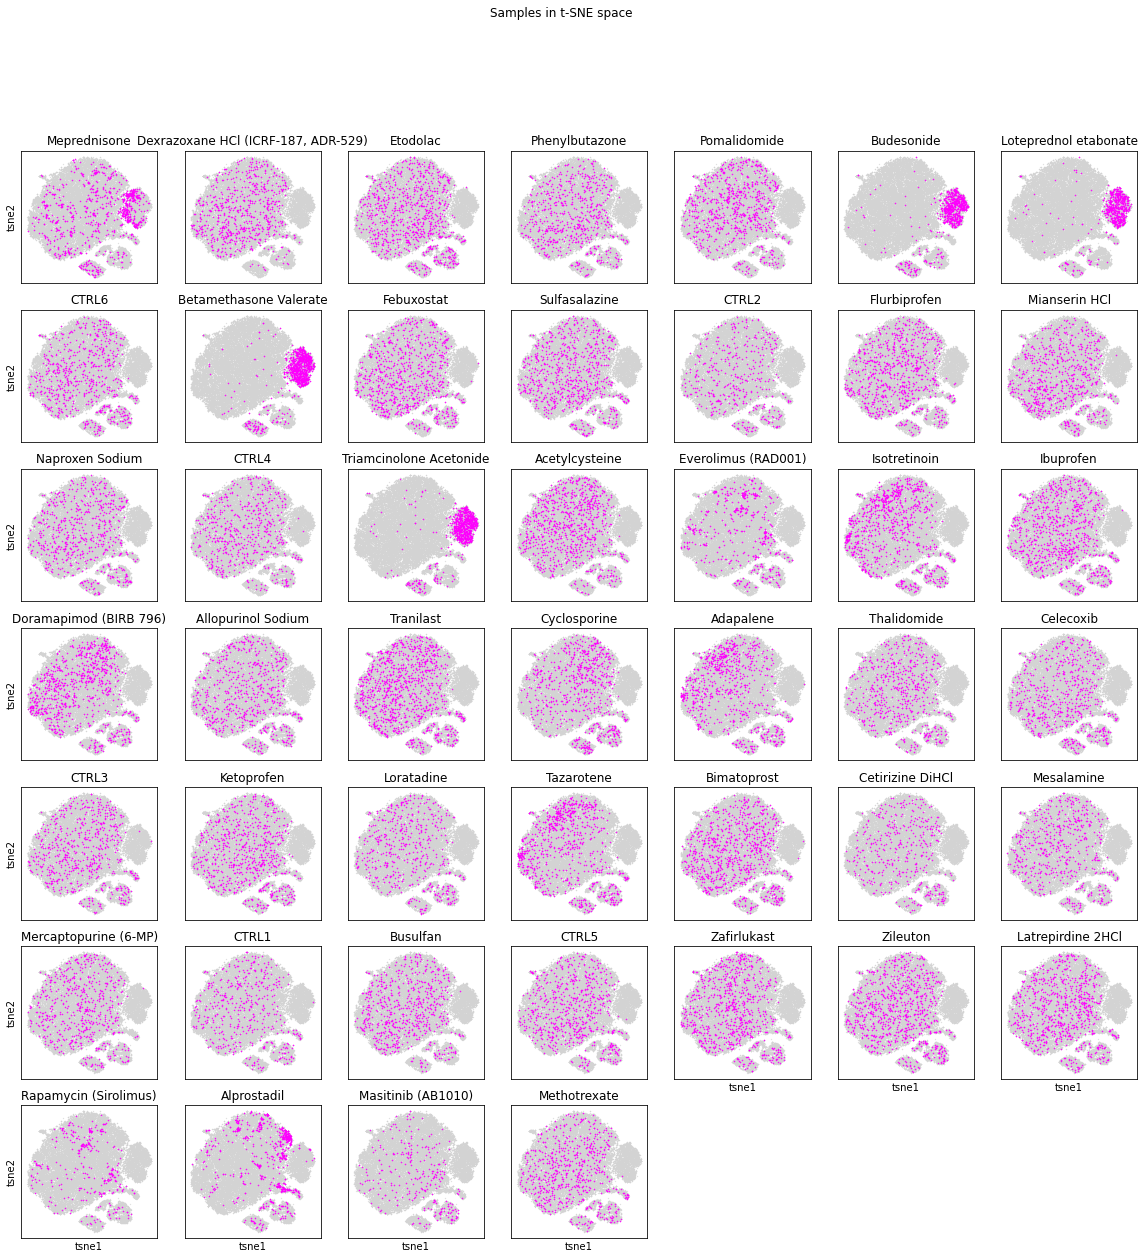

In [ ]:
'''
Generate a grid plot of sample plots in an embedding space

Parameters
----------
pop : dict
  Popalign object
method : str
  Embedding method. One of tsne, umap
figsize : tuple
  Figure size
size_background : float, int
  Point size for the embedding scatter in the background
size_samples : float, int
  Point size for the highlighted samples
showplot: bool
  whether to show the plot inline
'''
PA.samples_grid(pop, method='tsne', figsize=(20,20), size_background=.1, size_samples=.3, samplecolor='magenta', showplot=True)


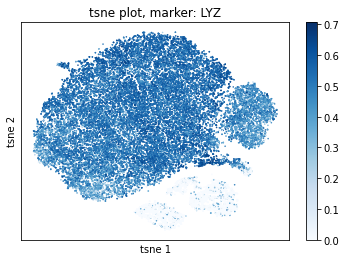

In [ ]:
'''
Run an embedding algorithm and plot the data in a scatter plot

pop: dict
  Popalign object
method : str
  Embedding method. One of umap, tsne. Defaults to umap
marker : str
  Either `samples` or a valid gene symbol. Defaults to None
size : float or int
  Point size. Defaults to .1
extension: string
  File extension like 'png' or 'pdf' to designate how to save the plot
showplot: bool
  whether to show the plot inline
'''
PA.scatter(pop, method='tsne', sample=None, compnumber=None, marker='LYZ', size=.3, extension='pdf', cmap='Blues',samplecolor='red', showplot=True)